# Behavioral Cloning Project

## Libraries

In [1]:
import os
import csv
import cv2
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Lambda, Flatten, Dense, Convolution2D, Dropout
from keras.models import load_model
from keras import callbacks
from keras.optimizers import Adam

Using TensorFlow backend.


## Constants

In [2]:
# Correction to apply for left and right camera images to simulate additonal data
correction = 0.25

# Range of pixels to translate the image
trans_range = 20

Load different datasets

In [3]:
dataLocation = './data/Udacity/'
#dataLocation = './data/MyData/'
#dataLocation = './data/Track2/'

Udacity data appears to be recorded on a linux machine wheras I am running windows. The directory separaters are opposite each other

In [4]:
directorySplitter = '/'
#directorySplitter = '\\'

## Load Training Logs

In [5]:
samples = []
with open(dataLocation + 'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# to remove header in Udacity dataset
# can leave it in for recorded data as missing one frame is negligible
samples.pop(0)

['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

## Split Training and Validation Samples

In [6]:
train_samples, validation_samples = train_test_split(samples, test_size = 0.2)

## Image Preprocessing

Crop top and bottom images to remove sky and front of the car.

Then scale the image to be equivalent to NVIDIA's paper

In [7]:
def image_preprocessing(image):
    # crop to 90x320x3
    image = image[50:140,:,:]
    
    # scale to 66x200x3 (same as NVIDIA)
    image = cv2.resize(image,(200, 66), interpolation = cv2.INTER_AREA)

    # convert to YUV color space (same as NVIDIA)
    return cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

## Generators

In [8]:
def generator_training(samples, batch_size=32):
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, len(samples), batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                center_image = cv2.imread(dataLocation + '/IMG/'+batch_sample[0].split(directorySplitter)[-1])
                left_image = cv2.imread(dataLocation + '/IMG/'+batch_sample[1].split(directorySplitter)[-1])
                right_image = cv2.imread(dataLocation + '/IMG/'+batch_sample[2].split(directorySplitter)[-1])
                
                center_angle = float(batch_sample[3])
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                
                # Randomly flips the images to help create even amount of left turns and right turns
                if np.random.rand() > .5:
                    center_image = cv2.flip(center_image, 1)
                    left_image = cv2.flip(left_image, 1)
                    right_image = cv2.flip(right_image, 1)
                    center_angle *= -1
                    left_angle *= -1
                    right_angle *= -1
                
                images.append(image_preprocessing(center_image))
                images.append(image_preprocessing(left_image))
                images.append(image_preprocessing(right_image))

                angles.append(center_angle)
                angles.append(left_angle)
                angles.append(right_angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [9]:
def generator_validation(samples, batch_size=32):
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, len(samples), batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                center_image = cv2.imread(dataLocation + '/IMG/'+batch_sample[0].split(directorySplitter)[-1])
                left_image = cv2.imread(dataLocation + '/IMG/'+batch_sample[1].split(directorySplitter)[-1])
                right_image = cv2.imread(dataLocation + '/IMG/'+batch_sample[2].split(directorySplitter)[-1])
                
                center_angle = float(batch_sample[3])
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                
                images.append(image_preprocessing(center_image))
                images.append(image_preprocessing(left_image))
                images.append(image_preprocessing(right_image))
                
                angles.append(center_angle)
                angles.append(left_angle)
                angles.append(right_angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [10]:
# compile and train the model using the generator function
train_generator = generator_training(train_samples, batch_size = 256)
validation_generator = generator_validation(validation_samples, batch_size = 256)

## Model Architecture

In [11]:
def nvidia_model():   
    model = Sequential()
    
    model.add(Lambda(lambda x: x/127.5 - 1.0, input_shape = (66,200,3)))
    
    model.add(Convolution2D(24, 5, 5, subsample = (2, 2), border_mode = "valid", activation = 'elu'))
    model.add(Convolution2D(36, 5, 5, subsample = (2, 2), border_mode = "valid", activation = 'elu'))
    model.add(Convolution2D(48, 5, 5, subsample = (2, 2), border_mode = "valid", activation = 'elu'))
    model.add(Convolution2D(64, 3, 3, subsample = (1, 1), border_mode = "valid", activation = 'elu'))
    model.add(Convolution2D(64, 3, 3, subsample = (1, 1), border_mode = "valid", activation = 'elu'))
    
    model.add(Flatten())
    
    model.add(Dense(100, activation = 'elu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation = 'elu'))
    model.add(Dropout(0.3))
    model.add(Dense(10, activation = 'elu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation = 'elu'))
    
    model.summary()
    
    return model

In [12]:
# For creating a new model
model = nvidia_model()

# Load the pretrained model to train on another data set
#model = load_model('model.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 200, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 47, 36)    21636       convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 5, 22, 48)     43248       convolution2d_2[0][0]            
___________________________________________________________________________________________

## Training the Model

In [13]:
model_path = os.path.expanduser('model.h5')
save_best = callbacks.ModelCheckpoint(model_path, 
                                      monitor = 'val_loss', 
                                      verbose = 1, 
                                      save_best_only = True, 
                                      mode = 'min')
early_stop = callbacks.EarlyStopping(monitor = 'val_loss', 
                                     min_delta = 0.001, 
                                     patience = 3, 
                                     verbose = 0, 
                                     mode = 'auto')
callbacks_list = [early_stop, save_best]

model.compile(loss = 'mse', optimizer = 'adam')
history_object = model.fit_generator(train_generator, 
                                     samples_per_epoch = len(train_samples)*3, # 3 images per frame
                                     validation_data = validation_generator,
                                     nb_val_samples = len(validation_samples)*3, # 3 images per frame
                                     nb_epoch = 15,
                                     callbacks = callbacks_list)

Epoch 1/15
19284/19284 [==============================] - 62s - loss: 0.0594 - val_loss: 0.0354
Epoch 2/15
19284/19284 [==============================] - 50s - loss: 0.0382 - val_loss: 0.0322
Epoch 3/15
19284/19284 [==============================] - 50s - loss: 0.0328 - val_loss: 0.0284
Epoch 4/15
19284/19284 [==============================] - 50s - loss: 0.0299 - val_loss: 0.0272
Epoch 5/15
19284/19284 [==============================] - 50s - loss: 0.0287 - val_loss: 0.0258
Epoch 6/15
19284/19284 [==============================] - 50s - loss: 0.0276 - val_loss: 0.0264
Epoch 7/15
19284/19284 [==============================] - 50s - loss: 0.0275 - val_loss: 0.0265
Epoch 8/15
19284/19284 [==============================] - 50s - loss: 0.0259 - val_loss: 0.0249
Epoch 9/15
19284/19284 [==============================] - 50s - loss: 0.0252 - val_loss: 0.0249


## Visualize losses

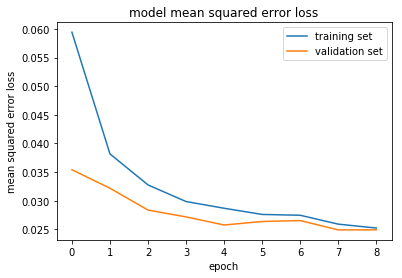

In [14]:
# plot the training and validation loss for each epoch
plt.figure
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()